In [23]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as data_sets
from torch.utils.data import random_split
from torchvision.utils import make_grid
import torch.nn.functional as F
from torch.autograd import Variable
from torch.optim.lr_scheduler import StepLR

from bokeh.plotting import figure
from bokeh.io import show
from bokeh.models import LinearAxis, Range1d
import numpy as np
import sklearn.metrics as sk

import matplotlib
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

downloading data

In [2]:
import torchvision.datasets as data_sets
mnist_train_data=data_sets.MNIST('mnist', train=True, download=True, transform=transforms.ToTensor())
mnist_test_data=data_sets.MNIST('mnist', train=False, transform=transforms.ToTensor())


Extracting mnist/MNIST/raw/train-images-idx3-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/train-labels-idx1-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/t10k-images-idx3-ubyte.gz to mnist/MNIST/raw




Extracting mnist/MNIST/raw/t10k-labels-idx1-ubyte.gz to mnist/MNIST/raw

Processing...
Done!


splitting train data into train and developement sets

In [3]:
developement_size=18000
mnist_train_data, mnist_developement_set = random_split(mnist_train_data, [len(mnist_train_data) - developement_size, developement_size])

In [4]:
print('Train Dataset :', len(mnist_train_data), "\nValidation Dataset:" ,len(mnist_developement_set))

Train Dataset : 42000 
Validation Dataset: 18000


setting batch size as 128

In [5]:
batch_size = 128

Loading train test and developement data

In [6]:
train_data_loader = DataLoader(dataset=mnist_train_data,batch_size= batch_size,num_workers=2,pin_memory=True,shuffle=True)
developement_data_loader = DataLoader(dataset = mnist_developement_set,batch_size = batch_size*2,num_workers=2,pin_memory=True)
test_data_loader = DataLoader(dataset=mnist_test_data,batch_size= batch_size,num_workers=2,pin_memory=True,shuffle=False)

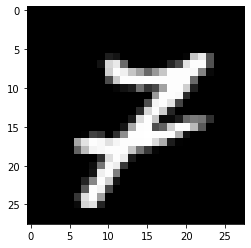

In [7]:
plt.imshow(mnist_train_data[0][0][0], cmap="gray")

Shape of Images: torch.Size([128, 1, 28, 28])


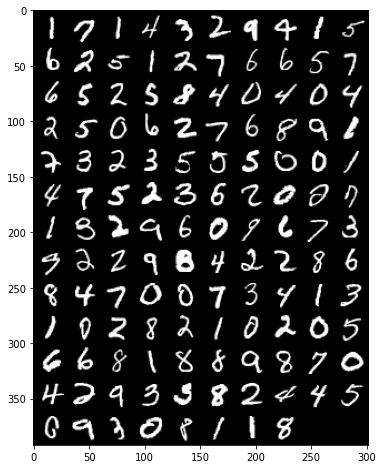

In [8]:
iterobj = iter(train_data_loader)
images, labels = iterobj.next()
print('Shape of Images:', images.shape)
plt.figure(figsize=(16,8))
plt.imshow(make_grid(images, nrow=10).permute((1, 2, 0)))

building the CNN model with 2 hidden layers, with relu activation, max pooling and 2 fully connected layers with xavier/glorot initialising. 

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels=1,out_channels= 32,kernel_size=5,stride=1,padding=2)
        self.relu1 = nn.ReLU()
        self.maxpool1 = nn.MaxPool2d(kernel_size=2, stride=2)
    
        self.conv2 = nn.Conv2d(in_channels=32,out_channels=64,kernel_size=5,stride=1,padding=2)    
        self.relu2 = nn.ReLU()  
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        
        self.fc1 = nn.Linear(7 * 7 * 64, 1000)
        nn.init.xavier_normal_(self.fc1.weight)
        
        self.fc2 = nn.Linear(1000, 10)
        nn.init.xavier_normal_(self.fc2.weight)

    def forward(self, batch_data):
        batch_data = self.conv1(batch_data)
        batch_data = self.relu1(batch_data)
        batch_data = self.maxpool1(batch_data)
       
        batch_data = self.conv2(batch_data)
        batch_data = self.relu2(batch_data)
        batch_data = self.maxpool1(batch_data)
      
        batch_data = batch_data.reshape(batch_data.size(0), -1)
    
        batch_data = self.fc1(batch_data)
        batch_data = self.fc2(batch_data)
        return batch_data
    
    def train_each_batch(self, images, labels):
        result = self(images)
        loss = Loss(result, labels)
        return loss

    def develope_each_batch(self, images, labels):
        # images =  batch[0]
        # labels = batch[1]
        result = self(images)                   
        loss = Loss(result, labels)
        acc = accuracy(result, labels)      
        return {'loss_at_end_of_batch': loss, 'acc_at_end_of_batch': acc}
      
    def develope_at_end_of_epoch(self, results):
        losses_at_end_of_batch = [x['loss_at_end_of_batch'] for x in results]
        loss_at_end_of_epoch = torch.stack(losses_at_end_of_batch).mean()  
        accs_at_each_batch = [x['acc_at_end_of_batch'] for x in results]
        acc_at_end_of_epoch = torch.stack(accs_at_each_batch).mean() 
        return {'loss_at_end_of_epoch': loss_at_end_of_epoch.item(), 'acc_at_end_of_epoch': acc_at_end_of_epoch.item()}

    def display_metrics_at_end_of_epoch(self, epoch, result):
        print("acc_at_end_of_epoch: {:.4f}, loss_at_end_of_epoch: {:.4f}".format(result['acc_at_end_of_epoch'], result['loss_at_end_of_epoch']))

helper function to calculate accuracy 

In [10]:
def accuracy(results, labels):
    _, predictions = torch.max(results, dim=1)
    return torch.tensor(torch.sum(predictions == labels).item() / len(predictions))

helper function to validate model with network

In [11]:
def develope(network, developement_data_loader):
    results = [network.develope_each_batch(images, labels) for j, (images, labels) in enumerate(developement_data_loader)]
    return network.develope_at_end_of_epoch(results)

creating an instance of model as network

In [12]:
network=CNN()

setting loss as CrossEntropyLoss, optimizer as schocastic gradient descent with starting learning rate as 0.05 and momentum 0.9 we set schedular with stepLR, for every 10 epochs the learning rates decrease by 0.1

In [13]:
Loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(network.parameters(), lr = 0.05, momentum = 0.9)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

train data with epochs and learning rate using helper functions created in CNN class. returns loss and accuracy collected while validating the developement set over all epochs

In [14]:
def train(epochs, model, train_data_loader, developement_data_loader, optimizer):    
    epoch_metrics = []
    for epoch in range(epochs): 
        lr = scheduler.step()
        print('Epoch:', epoch,'Learning rate:', scheduler.get_lr())
        for j,(images, labels) in enumerate(train_data_loader):
            loss = model.train_each_batch(images, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        result = develope(model, developement_data_loader)
        model.display_metrics_at_end_of_epoch(epoch, result)
        epoch_metrics.append(result)
        print("\n")
    return epoch_metrics

collecting and displaying accuracy and loss at each epoch

In [15]:
metrics_history = train(10, network, train_data_loader, developement_data_loader, optimizer)

Epoch: 0 Learning rate: [0.05]
acc_at_end_of_epoch: 0.9790, loss_at_end_of_epoch: 0.0678


Epoch: 1 Learning rate: [0.05]
acc_at_end_of_epoch: 0.9774, loss_at_end_of_epoch: 0.0713


Epoch: 2 Learning rate: [0.05]
acc_at_end_of_epoch: 0.9830, loss_at_end_of_epoch: 0.0514


Epoch: 3 Learning rate: [0.05]
acc_at_end_of_epoch: 0.9861, loss_at_end_of_epoch: 0.0453


Epoch: 4 Learning rate: [0.05]
acc_at_end_of_epoch: 0.9877, loss_at_end_of_epoch: 0.0453


Epoch: 5 Learning rate: [0.05]
acc_at_end_of_epoch: 0.9878, loss_at_end_of_epoch: 0.0442


Epoch: 6 Learning rate: [0.05]
acc_at_end_of_epoch: 0.9850, loss_at_end_of_epoch: 0.0550


Epoch: 7 Learning rate: [0.05]
acc_at_end_of_epoch: 0.9876, loss_at_end_of_epoch: 0.0506


Epoch: 8 Learning rate: [0.05]
acc_at_end_of_epoch: 0.9840, loss_at_end_of_epoch: 0.0587


Epoch: 9 Learning rate: [0.0005000000000000001]
acc_at_end_of_epoch: 0.9903, loss_at_end_of_epoch: 0.0392




In [16]:
if torch.cuda.is_available():
    device=torch.device("cuda:0")
else:
    device=torch.device("cpu")
print(device)

cpu


testing the model built

In [25]:
def test(network, test_data_loader):
  network.eval()
  with torch.no_grad():
    correct = 0
    total = 0
    actuals = []
    predictions = []
    for images, labels in test_data_loader:
        images = Variable(images)
        results = network(images)
        prediction = results.argmax(dim=1, keepdim=True)
        actuals.extend(labels.view_as(prediction))
        predictions.extend(prediction)
    return [i.item() for i in actuals], [i.item() for i in predictions]

#     return (correct / total) * 100

In [26]:
# acc_of_test=test(network, test_data_loader)
print("After Test : ")
# print("Accuracy of the model :",acc_of_test)
actuals, predictions = test(network, test_data_loader)
print('Confusion matrix:')
print(sk.confusion_matrix(actuals, predictions))


After Test : 
Confusion matrix:
[[ 978    0    0    0    0    0    1    1    0    0]
 [   0 1129    2    0    1    0    2    0    1    0]
 [   2    1 1022    0    0    0    0    6    1    0]
 [   1    0    2 1002    0    2    0    1    2    0]
 [   0    1    1    0  977    0    1    0    0    2]
 [   1    0    0    4    0  886    1    0    0    0]
 [   2    2    0    0    2    4  944    0    4    0]
 [   0    1    3    0    1    0    0 1020    1    2]
 [   2    0    2    1    0    1    0    1  966    1]
 [   1    1    0    0    4    5    0    2    1  995]]


In [28]:
print('Accuracy score: %f' % sk.accuracy_score(actuals, predictions))


Accuracy score: 0.991900


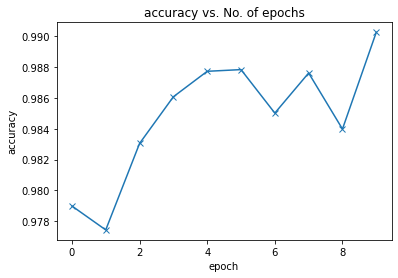

In [29]:
accs=[x['acc_at_end_of_epoch'] for x in metrics_history]
plt.plot(accs, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('accuracy vs. No. of epochs');

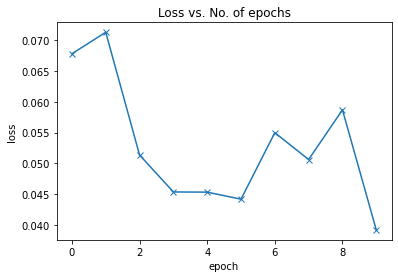

In [30]:
losses = [x['loss_at_end_of_epoch'] for x in metrics_history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs');

Baseline:

the baseline model reasonably fits the data, the accuracy obtained after test is around 99.2%
this model was run only for 10 epochs, and as shown above the learning rate does change at the last epoch by the gamma value as specified in the schedular. We couldnt run it for more epochs as there was a hardware limit, and our system was responding really slowly. 

But as we understand it, if we were to run it for more epochs, with learning rate changing every 10 epochs, we could have achieved accuracy which is almost 100. 